# **Nama  : Maulana Agus Setiawan**
# **NIM   : 2209106024**

LINK DATASET  : [Face Mask Detection](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset)

# **Import Library**

In [1]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

# **Load Dataset**

In [2]:
train_img_path = '/content/drive/MyDrive/Tugas semester 6/Computer Vision/Face Mask Dataset/Train'
val_img_path = '/content/drive/MyDrive/Tugas semester 6/Computer Vision/Face Mask Dataset/Validation'
test_img_path = '/content/drive/MyDrive/Tugas semester 6/Computer Vision/Face Mask Dataset/Test'

# **Augmentasi & Normalisasi**
#### `rescale=1./255` digunakan untuk Normalisasi piksel dari 0–255 ke 0–1 mempercepat konvergensi dan stabilisasi pelatihan. Lalu Augmentasi (`rotasi, zoom, geser, flip`) digunakan untuk Meniru variasi nyata dari wajah di dunia nyata, Membantu mencegah overfitting dengan menciptakan data baru dari data asli. Membuat model lebih robust terhadap perubahan sudut, posisi, dan pencahayaan.

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# **Data Generator**
#### Tujuannya untuk Memuat gambar langsung dari folder secara efisien dalam bentuk batch. Hal ini dilakukan untuk menghindari loading seluruh dataset ke memori, dan otomatis menerapkan augmentasi.

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_img_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

val_generator = train_datagen.flow_from_directory(
    val_img_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = train_datagen.flow_from_directory(
    test_img_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


# **Menampilkan Label Kelas**
#### Menyimpan nama kelas dalam list agar bisa digunakan untuk visualisasi dan evaluasi.

In [5]:
class_names = list(train_generator.class_indices.keys())
class_names

['WithMask', 'WithoutMask']

# **Visualisasi Sampel Gambar**
#### Mengecek apakah augmentasi dan label sudah benar. Hal ini dilakukan untuk Verifikasi manual sebelum melatih model, karena sangat penting agar tidak ada kesalahan label/augmentasi.

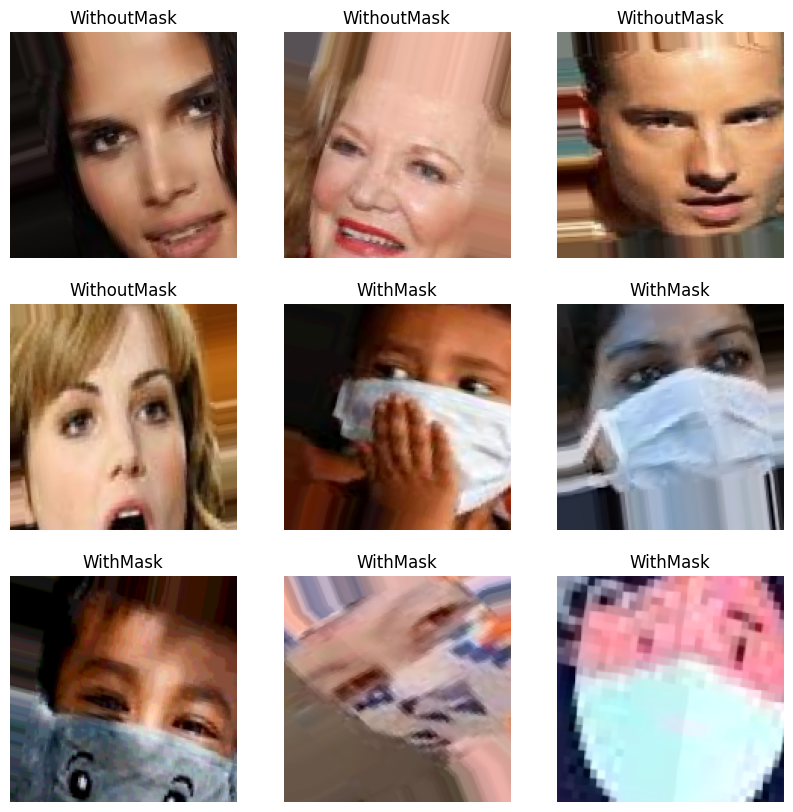

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        predicted_class_index = np.argmax(labels[i])
        plt.title(class_names[predicted_class_index])
        plt.axis("off")
    break
plt.show()

# **Arsitektur CNN**
#### Layer CNN digunakan untuk:

*   `Conv2D`: Menangkap pola lokal seperti tepi, bentuk wajah.
*   `MaxPooling`: Mengurangi dimensi dan menonjolkan fitur penting.
*  ` Dropout`: Mencegah overfitting dengan mengabaikan neuron secara acak saat pelatihan.
* `Flatten + Dense`: Untuk klasifikasi berdasarkan fitur yang telah diekstraksi.

In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,044,034 (3.98 MB)

 Trainable params: 1,044,034 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

# **Kompilasi Model**
#### Menggunakan `Optimizer Adam` karena Optimizer populer yang cepat dan stabil. `Categorical Crossentropy` digunakan Karena kita melakukan klasifikasi multi-kelas (lebih dari 1 output neuron).

In [9]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **Callbacks Early Stopping & Melatih Model**
#### Melatih model dengan epochs 20 serta menggunakan callback `early stopping`. Tujuan early stopping yaitu menghentikan pelatihan jika akurasi validasi tidak membaik dalam beberapa epoch. hal ini dilakukan agar mencegah pelatihan berlebih (`overfitting`) dan menghemat waktu.


In [10]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 155s 463ms/step - accuracy: 0.8585 - loss: 0.3234 - val_accuracy: 0.9425 - val_loss: 0.1803
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 98s 315ms/step - accuracy: 0.9339 - loss: 0.1794 - val_accuracy: 0.9563 - val_loss: 0.1185
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 103s 328ms/step - accuracy: 0.9465 - loss: 0.1569 - val_accuracy: 0.9638 - val_loss: 0.1277
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 103s 330ms/step - accuracy: 0.9447 - loss: 0.1561 - val_accuracy: 0.9638 - val_loss: 0.1245
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 316ms/step - accuracy: 0.9439 - loss: 0.1600 - val_accuracy: 0.9625 - val_loss: 0.1135
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 100s 320ms/step - accuracy: 0.9521 - loss: 0.1367 - val_accuracy: 0.9613 - val_loss: 0.1319
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 320ms/step - accuracy: 0.9487 - loss: 0.1355 - val_accuracy: 0.9588 - val_loss: 0.1176
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 99s 317ms/step - accuracy: 0.9652 - l

# **Evaluasi Akhir**
#### Tujuannya untuk mengukur kinerja akhir model pada data yang belum pernah dilihat.

In [11]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test Accuracy:', test_acc)
print('Test Loss: ', test_loss)

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - accuracy: 0.9766 - loss: 0.0632
Test Accuracy: 0.9788306355476379
Test Loss:  0.06778968125581741


# **Visualisasi Hasil Pelatihan**
#### Hal ini dilakukan untuk memantau performa model selama epoch dan membantu mendeteksi overfitting jika `val_accuracy` menurun sementara `train_accuracy` naik.

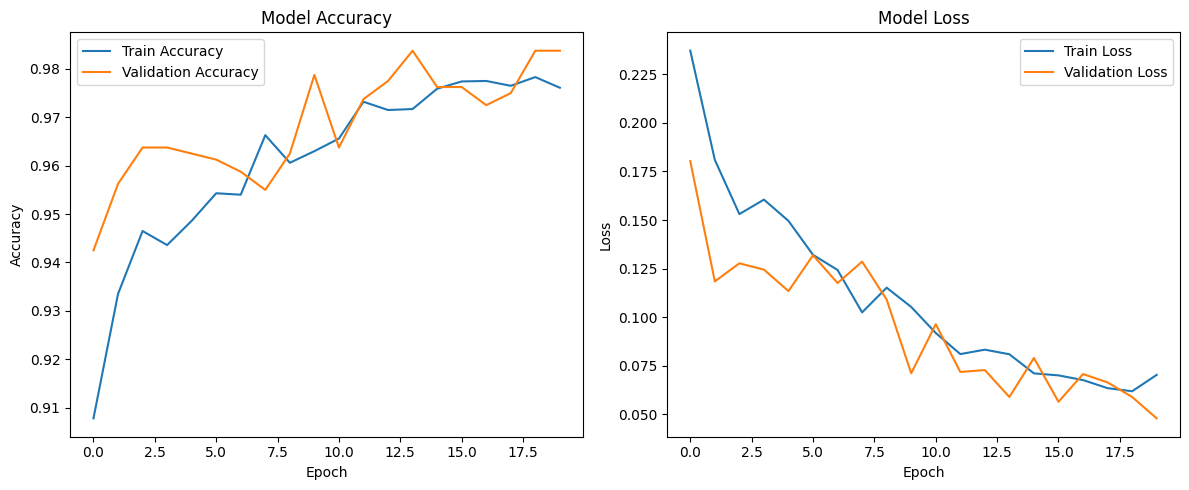

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Visualisasi Prediksi Acak**
#### Digunakan untuk menampilkan beberapa gambar acak dari` test set`. Prediksi ditampilkan dan dibandingkan dengan `label` asli. Judul warna `hijau` untuk prediksi **benar**, `merah` jika **salah** hal ini dilakukan untuk memudahkan identifikasi kesalahan model secara visual.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


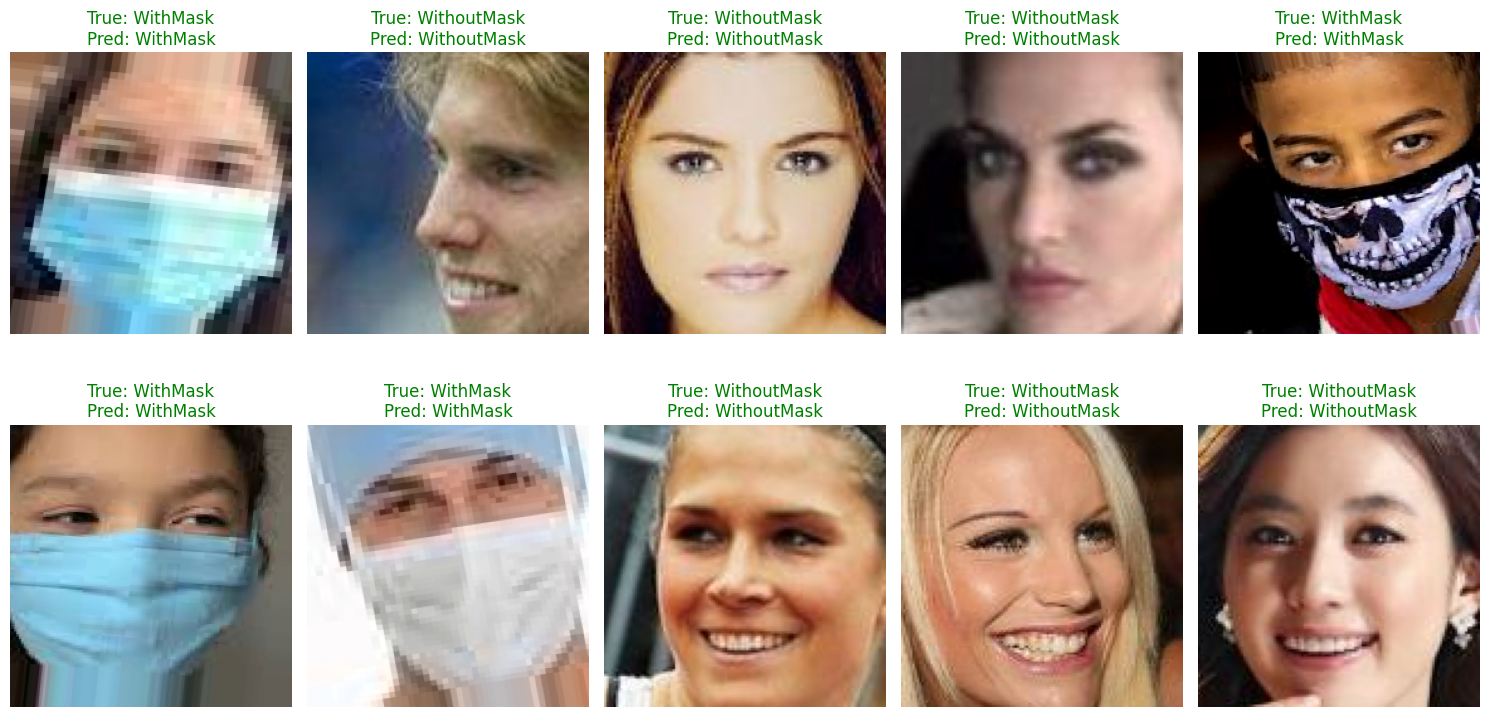

In [21]:
def visualize_sample_predictions(model, folder_path, class_names, num_samples=10, target_size=(150, 150)):

    image_paths = []
    labels = []

    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        for img_file in os.listdir(class_folder):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_folder, img_file))
                labels.append(class_name)

    indices = random.sample(range(len(image_paths)), num_samples)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        true_label = labels[idx]

        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(image_rgb, target_size)
        normalized = resized.astype('float32') / 255.0
        input_img = np.expand_dims(normalized, axis=0)

        prediction = model.predict(input_img)
        pred_label = class_names[np.argmax(prediction)]

        plt.subplot(2, (num_samples + 1) // 2, i + 1)
        plt.imshow(image_rgb)
        plt.title(f"True: {true_label}\nPred: {pred_label}",
                  color='green' if true_label == pred_label else 'red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_sample_predictions(model, test_img_path, class_names, num_samples=10)